# Imports

In [1]:
# imports

import os, sys
import numpy as np
import SimpleITK as sitk

from helpers_general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_metrics import compute_dice_coefficient, compute_coverage_coefficient
from helpers_viz import viz_axis

In [2]:
# auto-reload when local helper fns change
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [3]:
# Data path

PROJ_PATH = "."

# Folders containing MR train data
train_path = f"{PROJ_PATH}/train_data/train_data"
train_data_dict = get_data_dict(train_path)

# print train data dict
print(f"Train data folders: {numbers2groups(sorted([int(x) for x in os.listdir(train_path)]))}")
print(f"Training data: key = train folder, value = full path to (segm obj, nii file)\n")

Train data folders: [range(50002, 50017), range(50019, 50020), 50049, range(50455, 50464)]
Training data: key = train folder, value = full path to (segm obj, nii file)



### Atlas

In [4]:
# Load atlas: atlas MRs (10 MRs labelled by Dr. Hollon, need nii LPS=>RAS adjustment)

atlas_range, ras_adj = range(50455, 50464), True
atlas_folders = [str(i) for i in atlas_range]
atlas_objs, atlas_mask_objs = zip(*[folder2objs(atlas_folder, train_data_dict, ras_adj) \
                               for atlas_folder in atlas_folders])

### Input

In [5]:
# Load input: set input MRs (Samir's, no RAS adj needed for mask)

input_range, ras_adj = range(50002, 50017), False
input_folders = [str(i) for i in input_range]
input_objs, input_mask_objs = zip(*[folder2objs(input_folder, train_data_dict, ras_adj) \
                               for input_folder in input_folders])

### Crop to Foreground

In [6]:
def lmap(fn, arr, unpack_input=False, unpack_output=False):
    output = [fn(*o) for o in arr] if unpack_input else [fn(o) for o in arr]
    return zip(*output) if unpack_output else output

In [7]:
# Crop https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
def threshold_based_crop(image, mask):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.  
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return (sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]), \
            sitk.RegionOfInterest(mask, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]))

In [8]:
cropped_atlas_objs, cropped_atlas_mask_objs = lmap(threshold_based_crop, zip(atlas_objs, atlas_mask_objs), unpack_input=True, unpack_output=True)
cropped_input_objs, cropped_input_mask_objs = lmap(threshold_based_crop, zip(input_objs, input_mask_objs), unpack_input=True, unpack_output=True)

In [9]:
idx = 0
print("Cropped Atlas", cropped_atlas_objs[idx].GetSize(), "Original", atlas_objs[idx].GetSize())
print("Cropped Input", cropped_input_objs[idx].GetSize(), "Original", input_objs[idx].GetSize())

Cropped Atlas (146, 422, 331) Original (160, 480, 512)
Cropped Input (165, 200, 206) Original (176, 256, 256)


### Resample to Standard Reference Domain

In [10]:
img_data = [(o.GetSize(), o.GetSpacing()) for o in cropped_atlas_objs + cropped_input_objs]

In [11]:
# src: https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb

dimension = 3 # 3D MRs
pixel_id = 2 # 16-bit signed integer

# Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
reference_physical_size = np.zeros(dimension)

#img_data = [(o.GetSize(), o.GetSpacing()) for o in (cropped_atlas_obj, cropped_input_obj)]
for img_sz, img_spc in img_data:
    reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                  for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
# Create the reference image with a zero origin, identity direction cosine matrix and dimension     
reference_origin = np.zeros(dimension)
reference_direction = np.identity(dimension).flatten()


# Isotropic (1,1,1) pixels
reference_spacing = np.ones(dimension)
reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

# Set reference image attributes
reference_image = sitk.Image(reference_size, pixel_id)
reference_image.SetOrigin(reference_origin)
reference_image.SetSpacing(reference_spacing)
reference_image.SetDirection(reference_direction)

reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

In [12]:
def resample(img, mask, interpolator = sitk.sitkLinear, default_intensity_value = 0.0):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value), \
            sitk.Resample(mask, reference_image, centered_transform, sitk.sitkNearestNeighbor, default_intensity_value)

In [13]:
atlas_objs, atlas_mask_objs = lmap(resample, zip(cropped_atlas_objs, cropped_atlas_mask_objs), unpack_input=True, unpack_output=True)
input_objs, input_mask_objs = lmap(resample, zip(cropped_input_objs, cropped_input_mask_objs), unpack_input=True, unpack_output=True)

In [14]:
# atlas
atlas_arrs        = lmap(sitk2np, atlas_objs)
atlas_mask_arrs   = lmap(sitk2np, atlas_mask_objs)
atlas_bbox_coords = lmap(mask2bbox, atlas_mask_arrs)

# input
input_arrs        = lmap(sitk2np, input_objs)
input_mask_arrs   = lmap(sitk2np, input_mask_objs)
input_bbox_coords = lmap(mask2bbox, input_mask_arrs)

### ROI info

In [15]:
from pandas import DataFrame

In [16]:
def is_bbox(arr, imin, imax, jmin, jmax, kmin, kmax):
    return np.all(arr[imin:imax, jmin:jmax, kmin:kmax])

def get_info_df_row(folder, obj, mask_arr, bbox_coord):
    #print(bbox_coord)
    shape0, shape1, shape2             = obj.GetSize()
    imin, imax, jmin, jmax, kmin, kmax = bbox_coord
    roi_size0, roi_size1, roi_size2    = imax-imin, jmax-jmin, kmax-kmin
    is_bbox_bool                       = is_bbox(mask_arr, *bbox_coord)
    
    return {"folder": folder, \
            "shape0": shape0, "shape1": shape1, "shape2": shape2, \
            "roi_size0": roi_size0, "roi_size1": roi_size1, "roi_size2": roi_size2, \
            "is_bbox": is_bbox_bool,
            "imin": imin, "imax":imax, \
            "jmin":jmin, "jmax": jmax, \
            "kmin": kmin, "kmax": kmax}
    
def get_info_df(folders, objs, mask_arrs, bbox_coords):
    return DataFrame([get_info_df_row(folder, obj, mask_arr, bbox) \
                      for folder, obj, mask_arr, bbox in zip(folders, objs, mask_arrs, bbox_coords)])

In [17]:
atlas_info_df = get_info_df(atlas_range, atlas_objs, atlas_mask_arrs, atlas_bbox_coords)
atlas_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50455,175,232,226,34,28,19,False,71,105,124,152,65,84
1,50456,175,232,226,31,25,17,False,70,101,126,151,85,102
2,50457,175,232,226,30,26,16,False,74,104,127,153,86,102
3,50458,175,232,226,26,24,20,False,74,100,126,150,79,99
4,50459,175,232,226,34,25,18,False,73,107,121,146,75,93
5,50460,175,232,226,30,28,16,False,74,104,124,152,66,82
6,50461,175,232,226,29,23,17,False,75,104,122,145,76,93
7,50462,175,232,226,32,25,17,False,72,104,126,151,83,100
8,50463,175,232,226,32,26,19,False,69,101,122,148,70,89


In [18]:
input_info_df = get_info_df(input_range, input_objs, input_mask_arrs, input_bbox_coords)
input_info_df

,folder,shape0,shape1,shape2,roi_size0,roi_size1,roi_size2,is_bbox,imin,imax,jmin,jmax,kmin,kmax
0,50002,175,232,226,39,29,22,False,74,113,130,159,101,123
1,50003,175,232,226,31,24,21,False,72,103,128,152,110,131
2,50004,175,232,226,37,29,27,False,68,105,125,154,95,122
3,50005,175,232,226,33,26,20,False,74,107,121,147,101,121
4,50006,175,232,226,31,26,21,False,72,103,121,147,95,116
5,50007,175,232,226,33,27,21,False,71,104,142,169,96,117
6,50008,175,232,226,31,24,19,False,75,106,137,161,101,120
7,50009,175,232,226,39,25,20,False,69,108,125,150,102,122
8,50010,175,232,226,26,22,18,False,79,105,121,143,104,122
9,50011,175,232,226,30,25,23,False,74,104,136,161,110,133


### Align

In [19]:
def atlas2pred(input_obj, atlas_obj, atlas_mask_obj):
    
    elastixImageFilter = sitk.ElastixImageFilter()

    # set parameter map
    param_folder = "ElastixParamFiles"
    param_files = ["affine.txt"]

    parameterMapVector = sitk.VectorOfParameterMap()
    for param_file in param_files:
        parameterMapVector.append(sitk.ReadParameterFile(f"{param_folder}/{param_file}"))
    elastixImageFilter.SetParameterMap(parameterMapVector)

    # set moving and fixed images (resample moving=>fixed using T:fixed=>moving)
    
    # input = fixed, atlas = moving
    elastixImageFilter.SetFixedImage(input_obj)
    elastixImageFilter.SetMovingImage(atlas_obj)
    elastixImageFilter.Execute()

    #pred_obj = elastixImageFilter.GetResultImage()

    # MAP MOVING (ATLAS BINARY ROI) ONTO FIXED (INPUT) 

    # set moving image (atlas)                                                    
    transformixImageFilter = sitk.TransformixImageFilter()
    transformixImageFilter.SetMovingImage(atlas_mask_obj)

    # set parameter map (Binary mask => nearest neighbor final interpolation)
    transformedParameterMapVector = elastixImageFilter.GetTransformParameterMap()
    transformedParameterMapVector[-1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformixImageFilter.SetTransformParameterMap(transformedParameterMapVector)

    # Execute transformation
    transformixImageFilter.Execute()
    
    # pred_mask_obj = transformixImageFilter.GetResultImage()
    return transformixImageFilter.GetResultImage()

# Align2 = Pred ROI

In [22]:
# seems like 10x50x50 is enough padding. Hacky!

def get_bbox_margin(objs, bbox_coords, pads=[10,60,60]):
    
    imin, imax, jmin, jmax, kmin, kmax = bbox_coords
    
    imin_pad, jmin_pad, kmin_pad = [max(0, m-pad) for m,pad in zip((imin, jmin, kmin), pads)]
    imax_pad, jmax_pad, kmax_pad = [min(sz, m+pad) for m,pad,sz in zip((imax, jmax, kmax), pads, objs[0].GetSize())]
    
    #print(imax_pad)
    
    return      (*[o[imin_pad:imax_pad, jmin_pad:jmax_pad, kmin_pad:kmax_pad] for o in objs], \
                (imin_pad, imax_pad, jmin_pad, jmax_pad, kmin_pad, kmax_pad))

In [21]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full_mask_arr(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr

In [23]:
def cascaded_align_row(input_obj, input_mask_obj, atlas_objs=atlas_objs, atlas_mask_obj=atlas_mask_objs, mult_factor=2):
    
    dice_scores = {}
    n_votes = len(atlas_objs)
    print(f"N={n_votes} atlases in the vote.")
    
    input_mask_arr = sitk2np(input_mask_obj)
    
    for i in range(n_votes):
        print(f"Getting pred for atlas {i}:")
        
        pred_mask_obj1 = atlas2pred(input_obj, atlas_objs[i], atlas_mask_objs[i])
        pred_mask_arr1 = sitk2np(pred_mask_obj1)
        bbox = mask2bbox(pred_mask_arr1)
        
        print("aligned1")

        # crop given 1st ROI estimation
        cropped_atlas_obj, cropped_atlas_mask_obj, cropped_input_obj, cropped_input_mask_obj, cropped_bbox_coords = \
            get_bbox_margin((atlas_objs[i], atlas_mask_objs[i], input_obj, input_mask_obj), bbox)
        
        # re-align
        try:
            pred_mask_obj2 = atlas2pred(cropped_input_obj, cropped_atlas_obj, cropped_atlas_mask_obj)
            pred_mask_arr2 = sitk2np(pred_mask_obj2)
        except:
            print("2nd alignment failed. 2nd align = 1st align")
            pred_mask_obj2 = get_bbox_margin([pred_mask_obj1], bbox)
            pred_mask_arr2 = sitk2np(pred_mask_arr1)
            
        print("aligned2")
        
        # compute dice
        dice1 = compute_dice_coefficient(input_mask_arr, pred_mask_arr1)
        dice2 = compute_dice_coefficient(sitk2np(cropped_input_mask_obj), pred_mask_arr2)
        
        # save dice
        dice_scores[f"dice{i}"]     = dice1
        dice_scores[f"csc_dice{i}"] = dice2
    
        # add atlas vote
        
        # convert pred_mask_arr2 to full (for voting, need standard size)
        bbox_within = mask2bbox(pred_mask_arr2)
        full_coords = get_full_coords(cropped_bbox_coords, bbox_within)
        full_mask_arr2 = cascade2full_mask_arr(input_mask_arr.shape, full_coords, pred_mask_arr2, bbox_within)
            
        if i == 0:
            vote_pred_mask_arr1 = pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 = full_mask_arr2.astype(np.uint8)
            
        else: 
            vote_pred_mask_arr1 += pred_mask_arr1.astype(np.uint8)
            vote_pred_mask_arr2 += full_mask_arr2.astype(np.uint8)

    # get avg dice score
    dice_scores[f"dice_avg"] = np.mean([v for k,v in dice_scores.items() if not k.startswith("csc")])
    dice_scores[f"csc_dice_avg"] = np.mean([v for k,v in dice_scores.items() if k.startswith("csc")])
    
    # get vote
    print(f"Getting vote dice")
    vote_pred_mask_arr1 = (vote_pred_mask_arr1 >= n_votes/2).astype(bool)
    vote_pred_mask_arr2 = (vote_pred_mask_arr2 >= n_votes/2).astype(bool)
    
    dice_scores[f"dice_vote_all"]     = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr1)
    dice_scores[f"csc_dice_vote_all"] = compute_dice_coefficient(input_mask_arr, vote_pred_mask_arr2)
    
    #print(dice_scores)
    return dice_scores

In [24]:
test_row = cascaded_align_row(input_objs[0], input_mask_objs[0], atlas_objs[:2], atlas_mask_objs[:2], mult_factor=2)

N=2 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting vote dice


In [25]:
test_df = DataFrame([test_row])
test_df

,dice0,csc_dice0,dice1,csc_dice1,dice_avg,csc_dice_avg,dice_vote_all,csc_dice_vote_all
0,0.678186,0.785946,0.668226,0.638441,0.673206,0.712194,0.724507,0.836223


In [26]:
cols = test_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [27]:
test_df[csc_cols]

,csc_dice0,csc_dice1,csc_dice_avg,csc_dice_vote_all
0,0.785946,0.638441,0.712194,0.836223


In [28]:
test_df[non_csc_cols]

,dice0,dice1,dice_avg,dice_vote_all
0,0.678186,0.668226,0.673206,0.724507


In [29]:
input_rows = [None] * len(input_range)
for i in range(len(input_range)):
    print(f"Row {i}: {input_range[i]}")
    
    try:
        input_rows[i] = cascaded_align_row(input_objs[i], input_mask_objs[i], atlas_objs, atlas_mask_objs, mult_factor=2)
    
        df = DataFrame([input_rows[i]])
        cols = df.columns.tolist()
        csc_cols = [c for c in cols if c.startswith("csc")]
        non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

        display(df[non_csc_cols])
        display(df[csc_cols])
        
    except Exception as e:
        pass
        #print("Message:\n ", e.message, "\n", "Args:\n ", e.args)
        

Row 0: 50002
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.678186,0.668226,0.685368,0.685387,0.562789,0.501625,0.485596,0.58001,0.687706,0.614988,0.631478


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.785946,0.638441,0.587758,0.638355,0.623902,0.635523,0.536019,0.632177,0.664253,0.638042,0.642607


Row 1: 50003
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.135532,0.597219,0.613296,0.513528,0.494177,0.0,0.458025,0.439019,0.498796,0.416621,0.48878


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.454302,0.741283,0.741947,0.659606,0.605458,0.553551,0.645969,0.594359,0.70854,0.633891,0.69139


Row 2: 50004
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.659506,0.633646,0.594588,0.62733,0.673344,0.606199,0.640773,0.661992,0.72422,0.646844,0.645412


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.750678,0.628008,0.628423,0.638737,0.606579,0.609073,0.554941,0.584429,0.69488,0.632861,0.623348


Row 3: 50005
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.51523,0.684062,0.623582,0.529251,0.729083,0.496184,0.724571,0.577252,0.731948,0.623463,0.632812


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.630671,0.789628,0.797721,0.812779,0.853799,0.668031,0.821605,0.732289,0.851211,0.773082,0.815172


Row 4: 50006
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.521236,0.692351,0.614088,0.590081,0.774078,0.564709,0.751085,0.628112,0.733372,0.652124,0.675706


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.618602,0.725194,0.714537,0.767803,0.807336,0.611753,0.762557,0.670975,0.775177,0.717104,0.744737


Row 5: 50007
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.73649,0.861922,0.795773,0.803387,0.793579,0.754082,0.670772,0.811099,0.855541,0.78696,0.855188


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.491438,0.83078,0.738043,0.831219,0.628338,0.642058,0.687344,0.824801,0.771814,0.716204,0.759865


Row 6: 50008
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.610639,0.881471,0.835453,0.779854,0.678204,0.082169,0.55704,0.707737,0.831083,0.662628,0.782357


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.407982,0.890664,0.818253,0.789482,0.735881,0.276036,0.743792,0.861013,0.801346,0.702716,0.815601


Row 7: 50009
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.111895,0.52952,0.533747,0.333393,0.300587,0.0,0.357487,0.462691,0.72264,0.37244,0.382489


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.605059,0.831188,0.832532,0.761589,0.759615,0.751942,0.753378,0.761008,0.862889,0.7688,0.839442


Row 8: 50010
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.004335,0.34972,0.46665,0.347063,0.014156,0.0,0.101582,0.197893,0.444986,0.214043,0.196284


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.524988,0.803552,0.807062,0.764456,0.743883,0.701439,0.747002,0.729967,0.740509,0.729206,0.799958


Row 9: 50011
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.321572,0.704313,0.750562,0.616812,0.305827,0.0,0.419136,0.523909,0.478586,0.457857,0.496639


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.335355,0.801847,0.616676,0.755957,0.585916,0.0,0.680725,0.691993,0.389653,0.539791,0.668045


Row 10: 50012
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.0,0.152733,0.392369,0.380809,0.0,0.0,0.176215,0.135832,0.056641,0.143844,0.150005


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.260304,0.766837,0.618788,0.675145,0.204127,0.340973,0.600552,0.736641,0.725521,0.547654,0.700921


Row 11: 50013
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.567694,0.728627,0.711624,0.584989,0.63254,0.300633,0.574014,0.614997,0.785522,0.611182,0.64632


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.681613,0.781654,0.735714,0.776912,0.698669,0.684755,0.673178,0.725187,0.8012,0.728765,0.778158


Row 12: 50014
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.627312,0.747565,0.811982,0.641168,0.728723,0.556309,0.667381,0.679791,0.81421,0.69716,0.742948


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.662798,0.805622,0.81133,0.788008,0.751521,0.837995,0.753097,0.800944,0.775085,0.776267,0.845103


Row 13: 50015
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.526162,0.450381,0.539332,0.430049,0.348105,0.059315,0.539316,0.415541,0.742774,0.450108,0.468395


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.731967,0.751966,0.762879,0.841601,0.742,0.771722,0.743585,0.752452,0.797736,0.766212,0.79727


Row 14: 50016
N=9 atlases in the vote.
Getting pred for atlas 0:
aligned1
aligned2
Getting pred for atlas 1:
aligned1
aligned2
Getting pred for atlas 2:
aligned1
aligned2
Getting pred for atlas 3:
aligned1
aligned2
Getting pred for atlas 4:
aligned1
aligned2
Getting pred for atlas 5:
aligned1
aligned2
Getting pred for atlas 6:
aligned1
aligned2
Getting pred for atlas 7:
aligned1
aligned2
Getting pred for atlas 8:
aligned1
aligned2
Getting vote dice


,dice0,dice1,dice2,dice3,dice4,dice5,dice6,dice7,dice8,dice_avg,dice_vote_all
0,0.380962,0.561163,0.617061,0.557455,0.572208,0.418687,0.459932,0.429513,0.644133,0.515679,0.536737


,csc_dice0,csc_dice1,csc_dice2,csc_dice3,csc_dice4,csc_dice5,csc_dice6,csc_dice7,csc_dice8,csc_dice_avg,csc_dice_vote_all
0,0.467168,0.720545,0.710731,0.834734,0.76085,0.735711,0.781139,0.639356,0.758851,0.712121,0.804421


In [31]:
import pandas as pd

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

<ipython-input-32-1390d13c0cdd>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [33]:
DataFrame(input_rows)

,dice0,csc_dice0,dice1,csc_dice1,dice2,csc_dice2,dice3,csc_dice3,dice4,csc_dice4,dice5,csc_dice5,dice6,csc_dice6,dice7,csc_dice7,dice8,csc_dice8,dice_avg,csc_dice_avg,dice_vote_all,csc_dice_vote_all
0,0.678186,0.785946,0.668226,0.638441,0.685368,0.587758,0.685387,0.638355,0.562789,0.623902,0.501625,0.635523,0.485596,0.536019,0.580010,0.632177,0.687706,0.664253,0.614988,0.638042,0.631478,0.642607
1,0.135532,0.454302,0.597219,0.741283,0.613296,0.741947,0.513528,0.659606,0.494177,0.605458,0.000000,0.553551,0.458025,0.645969,0.439019,0.594359,0.498796,0.708540,0.416621,0.633891,0.488780,0.691390
2,0.659506,0.750678,0.633646,0.628008,0.594588,0.628423,0.627330,0.638737,0.673344,0.606579,0.606199,0.609073,0.640773,0.554941,0.661992,0.584429,0.724220,0.694880,0.646844,0.632861,0.645412,0.623348
3,0.515230,0.630671,0.684062,0.789628,0.623582,0.797721,0.529251,0.812779,0.729083,0.853799,0.496184,0.668031,0.724571,0.821605,0.577252,0.732289,0.731948,0.851211,0.623463,0.773082,0.632812,0.815172
4,0.521236,0.618602,0.692351,0.725194,0.614088,0.714537,0.590081,0.767803,0.774078,0.807336,0.564709,0.611753,0.751085,0.762557,0.628112,0.670975,0.733372,0.775177,0.652124,0.717104,0.675706,0.744737
5,0.736490,0.491438,0.861922,0.830780,0.795773,0.738043,0.803387,0.831219,0.793579,0.628338,0.754082,0.642058,0.670772,0.687344,0.811099,0.824801,0.855541,0.771814,0.786960,0.716204,0.855188,0.759865
6,0.610639,0.407982,0.881471,0.890664,0.835453,0.818253,0.779854,0.789482,0.678204,0.735881,0.082169,0.276036,0.557040,0.743792,0.707737,0.861013,0.831083,0.801346,0.662628,0.702716,0.782357,0.815601
7,0.111895,0.605059,0.529520,0.831188,0.533747,0.832532,0.333393,0.761589,0.300587,0.759615,0.000000,0.751942,0.357487,0.753378,0.462691,0.761008,0.722640,0.862889,0.372440,0.768800,0.382489,0.839442
8,0.004335,0.524988,0.349720,0.803552,0.466650,0.807062,0.347063,0.764456,0.014156,0.743883,0.000000,0.701439,0.101582,0.747002,0.197893,0.729967,0.444986,0.740509,0.214043,0.729206,0.196284,0.799958
9,0.321572,0.335355,0.704313,0.801847,0.750562,0.616676,0.616812,0.755957,0.305827,0.585916,0.000000,0.000000,0.419136,0.680725,0.523909,0.691993,0.478586,0.389653,0.457857,0.539791,0.496639,0.668045


array([[<AxesSubplot:title={'center':'dice_vote_all'}>,
        <AxesSubplot:title={'center':'csc_dice_vote_all'}>]], dtype=object)

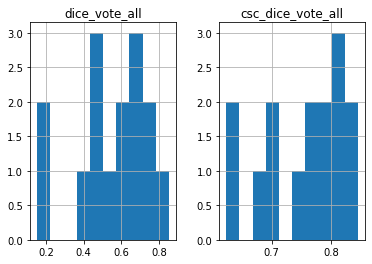

In [35]:
hist = DataFrame(input_rows).hist(column=["dice_vote_all", "csc_dice_vote_all"])
hist

In [ ]:
for i,test_row in enumerate(input_rows):
    print(f"Row {i}: {input_range[i]}")
    
    df = DataFrame([test_row])
    cols = df.columns.tolist()
    csc_cols = [c for c in cols if c.startswith("csc")]
    non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]
    
    display(df[non_csc_cols])
    display(df[csc_cols])

In [ ]:
input_df = DataFrame(cascaded_align_row(input_obj, input_mask_obj, atlas_objs, atlas_mask_objs, mult_factor=2)
                     for input_obj, input_mask_obj in zip(input_objs, input_mask_objs))

In [ ]:
cols = input_df.columns.tolist()
csc_cols = [c for c in cols if c.startswith("csc")]
non_csc_cols = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
input_df[csc_cols]

In [ ]:
input_df[non_csc_cols]

In [ ]:
def reorder_cols(df):
    cols = df.columns.tolist()
    csc = [c for c in cols if c.startswith("csc") and c]
    noncsc  = csc = [c for c in cols if not c.startswith("csc")]

In [ ]:
# pred_objs, pred_mask_objs = lmap(atlas2pred, zip(resampled_atlas_objs, resampled_atlas_mask_objs, resampled_input_objs), unpack_input=True)

In [ ]:
def get_offset(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin

def coords2pts(coords):
    imin, imax, jmin, jmax, kmin, kmax = coords
    return imin, jmin, kmin, imax, jmax, kmax

def pts2coords(coords):
    imin, jmin, kmin, imax, jmax, kmax = coords
    return imin, imax, jmin, jmax, kmin, kmax

#### H_0 Null

Align Atlas ROI + pad to full Input


In [ ]:
# imagine I have bbox within aligned loc (5,10,20) to (10,35,76)
bbox_within = pts2coords((5,10,20,10,35,76))
print_bbox(*bbox_within)

In [ ]:
# test
offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
coords_pts  = coords2pts(bbox_within)
full_coords = pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

print_bbox(*full_coords);


In [ ]:
def get_full_coords(cropped_bbox_coords, bbox_within):
    offset_pts  = get_offset(cropped_bbox_coords) * 2 # imin, jmin, kmin
    coords_pts  = coords2pts(bbox_within)
    return pts2coords([coord + offset for coord, offset in zip(coords_pts, offset_pts)])

def cascade2full(full_shape, full_bbox_coords, cascade_mask_arr, cascade_bbox_coords):
    full_arr = np.full(full_shape, False)
    
    imin, imax, jmin, jmax, kmin, kmax       = full_bbox_coords
    cimin, cimax, cjmin, cjmax, ckmin, ckmax = cascade_bbox_coords

    full_arr[imin:imax, jmin:jmax, kmin:kmax] = cascade_mask_arr[cimin:cimax, cjmin:cjmax, ckmin:ckmax]
    return full_arr


In [ ]:
# Viz

# Row 1. Full atlas w/ full coords
# Row 2. Cropped atlas w/ crop coords

viz_axis(np_arr = sitk2np(resampled_arr_objs[0]), \
        bin_mask_arr  = cascade_input_mask_arr, color1 = "yellow", alpha1=0.7, \
        bin_mask_arr2  = cascade_pred_mask_arr, color2 = "red", alpha2=0.7, \
        slices=cascade_input_slice_range, fixed_axis=0, \
        axis_fn = np.rot90, \
         
        np_arr_b = cascade_pred_arr, \
        bin_mask_arr_b  = cascade_pred_mask_arr, color1_b = "yellow", alpha1_b=0.3,
        slices_b = cascade_pred_slice_range,
         
        np_arr_c = cascade_atlas_arr, \
        bin_mask_arr_c  = cascade_atlas_mask_arr, color1_c = "yellow", alpha1_c=0.3,
        slices_c = cascade_atlas_slice_range,
         
        grid = [3, 8], hspace=0.3, fig_mult=2)